In [1]:
%matplotlib inline
%load_ext rpy2.ipython
repo = 'https://raw.githubusercontent.com/guester/Charleston-Data-Analytics-Cancer-Genomics-Data-Challenge/master/'

In [2]:
from sklearn.preprocessing import StandardScaler
non_features = ['tumorID', 'res_AUC', 'res_IC50', 'response']
response = 'response'
scaler = StandardScaler()

In [3]:
import os
import pickle
def fetch(url):
    fpath = '/tmp/genomics_analytics_'+url.split('/')[-1]+'.pkl'
    d = None
    if os.path.exists(fpath):
        d = pd.read_pickle(fpath)
    else:
        d = pd.read_csv(url)
        d.to_pickle(fpath)
        
    # Drop any columns that are exclusively NA
    d = d.dropna(axis=1, how='all')
    
    # Rename non feature columns
    return d.rename(columns={
            'Z_score':'response', 
            'response_metric_IC50':'res_IC50', 
            'response_metric_AUC':'res_AUC'
    })

In [4]:
datasets = {
    'cn': {'type': 'numeric'},
    'ge': {'type': 'numeric'},
    'mu': {'type': 'character'}
}

In [5]:
datasets['cn']['data'] = fetch(repo + 'copy_number.csv')

In [6]:
datasets['ge']['data'] = fetch(repo + 'gene_expression.csv')

In [7]:
datasets['mu']['data'] = fetch(repo + 'mutations.csv')

In [8]:
def all_datasets():
    return [d['data'] for d in datasets.values()]
    
def numeric_datasets():
    return [d['data'] for d in datasets.values() if d['type'] == 'numeric']

# Data Validation

Verify that no raw datasets contain non-feature values that the others do not:

In [9]:
def validate_equality(col, datasets):
    d = pd.DataFrame({i:d[col] for i, d in enumerate(datasets)})
    d = d.dropna(how='all')
    equals = d.apply(lambda x: len(np.unique(x)) == 1, axis=1)
    if not np.all(equals):
        print(d[~equals])
        raise ValueError('Found differing values in raw datasets for column {}'.format(col))

for col in non_features:
    validate_equality(col, all_datasets())

Find the tumor cases where all the numeric features from one of the numeric sets (d_cn_r or d_ge_r) are NA.  

At TOW, there were 4 cases where BOTH numeric data sets were all NA and 2 cases where one or the other was NA:

In [10]:
def get_na_fraction(d):
    return d.set_index(non_features)\
        .apply(lambda x: np.sum(pd.isnull(x))/len(x), axis=1)
null_frac = pd.concat([get_na_fraction(d) for d in numeric_datasets()], axis=1)
null_frac['avg'] = null_frac.mean(axis=1)
null_frac.sort('avg', ascending=False).head(10)

# Verify below that the 'avg' column is either 1 or 0
# If it is something in between, then extra logic will need to be added to
# deal with the situation where numeric datasets are "mostly" not null

,,,,0,1,avg
tumorID,res_AUC,res_IC50,response,,,
T3M10,0.86683,NaN,-2.04731296495318,1,1,1.0
HCC2108,hidden,hidden,hidden,1,1,1.0
HCC1359,6.383,NaN,1.20416156567861,1,1,1.0
HCC1833,4.0173,NaN,-0.190286628832373,1,1,1.0
NCIH2073,4.0688,NaN,-0.15993025143147,1,0,0.5
COLO699,4.5431,NaN,0.119643142767523,0,1,0.5
NCIH82,NaN,1.3502480183341599,1.3992087697351399,0,0,0.0
NCIH841,4.9514,NaN,0.36031321835565,0,0,0.0
NOMO1,4.7985,NaN,0.270187196907145,0,0,0.0


In [11]:
na_cases = null_frac[(null_frac[0] == 1.) | (null_frac[1] == 1.)].reset_index()['tumorID']
na_cases

0     COLO699
1     HCC1359
2     HCC1833
3     HCC2108
4    NCIH2073
5       T3M10
Name: tumorID, dtype: object

# Data Preparation

Now that we're sure that no data will be lost in a join on a non-feature column, merge all the raw datasets together and split them into training and holdout sets (based on whether or not the response is equal to 'hidden'):

In [12]:
# Merge all data on non-feature index

data = pd.concat([
    datasets[k]['data']\
        .set_index(non_features)\
        .rename(columns=lambda c: ':'.join([k, c])) \
    for k in datasets.keys()], 
    axis=1
).reset_index()

# Remove rows with all NA's in one of the numeric datasets (computed above)
data = data[~data['tumorID'].isin(na_cases)]

# Split into training and holdout
data_ho, data_tr = data[data.response == 'hidden'], data[data.response != 'hidden']
len(data_ho), len(data_tr)

(39, 210)

### Response Validation 

Verify that the given Z score (as column 'response') actually comes close to what you would get by doing the standardization across the two response metric types yourself:

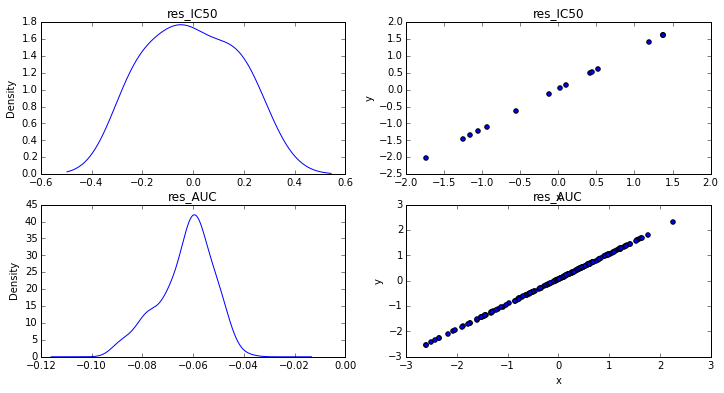

In [13]:
fig, g = plt.subplots(nrows=2, ncols=2); g = iter(g.ravel())
fig.set_size_inches((12, 6))
for col in ['res_IC50', 'res_AUC']:
    dt = data_tr[~data_tr[col].isnull()]
    d1 = scaler.fit_transform(dt[col].astype(np.float64))
    d2 = dt['response'].astype(np.float64)
    pd.Series(d1 - d2).plot(kind='kde', ax=next(g), title=col)
    pd.DataFrame({'x': d1, 'y': d2}).plot(kind='scatter', x='x', y='y', ax=next(g), title=col)
    
# Conclusion: There seems to be something of a bias in the way the z-score for 
# res_AUC was standardized (perhaps the holdout sets just randomly had higher values on average).

### Scaling and Encoding

In [16]:
import re
def prep_data(d):
    regex = re.compile('\w|-')
    res = {}
    for c in d:
        # If the column is a string, create a dummy encoding for the column
        # that includes NA but then uses NA as the reference level (by dropping it)
        if (d[c].dtype == np.object):
            feats = d[c].apply(lambda x: ''.join(regex.findall(x.replace(',', '-').replace('_', '-'))) if not pd.isnull(x) else x)
            feats = pd.get_dummies(feats, prefix=c, dummy_na=True, prefix_sep=':')\
                .drop(c + ':nan', axis=1)\
                .astype(np.int64)
            for feat in feats:
                assert feat not in res, 'Key "{}" already exists in result'.format(feat)
            res.update(feats)
        
        # If the column is a float, assure that it is always present and apply standardization
        elif (d[c].dtype == np.float64):
            assert not np.any(d[c].isnull()), 'Found NA values for column {}'.format(c)
            assert c not in res, 'Key "{}" already exists in result'.format(c)
            res[c] = scaler.fit_transform(d[c])
            
        else:
            raise ValueError('Data type "{}" for column "{}" is not yet supported'.format(d[c].dtype, c))
    return pd.DataFrame(res)

In [17]:
data_tr_prep = prep_data(data_tr.set_index(non_features))
data_ho_prep = prep_data(data_ho.set_index(non_features))

In [18]:
data_tr_prep.shape

(210, 53639)

# Save Training Data 

Write training data to csv for DataRobot

In [19]:
data_tr_prep.reset_index().drop(['tumorID', 'res_AUC', 'res_IC50'], axis=1)\
.to_csv('/Users/eczech/data/meetups/genomics/data.csv', index=False)

# Modeling

In [30]:
from ml.model import models, common, importances
import imp
imp.reload(models)
imp.reload(common)
imp.reload(importances)

<module 'ml.model.importances' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/model/importances.py'>

In [21]:
data_tr_prep.head()

,,,,cn:A1BG,cn:A1BG.AS1,cn:A1CF,cn:A2M,cn:A2M.AS1,cn:A2ML1,cn:A2MP1,cn:A4GALT,cn:A4GNT,cn:AAAS,...,mu:ZNF608:T758A,mu:ZNF608:V392A,mu:ZNF608:Y1245H,mu:ZNF668:P469L-A174V,mu:ZNF668:Q538Sfs14,mu:ZNF668:R151L,mu:ZNF717:L46Pfs24,mu:ZNF790:Q355Afs8,mu:ZNF841:Y776Ifs38,mu:ZSCAN31:P322Tfs3
tumorID,res_AUC,res_IC50,response,,,,,,,,,,,,,,,,,,,,,
A2780,5.0776,NaN,0.434701079093396,-0.098576,-0.098576,0.098841,0.065048,0.065048,0.060504,0.070635,0.548740,-0.475209,-0.412856,...,0,0,0,0,0,0,0,0,0,0
AGS,2.4581,NaN,-1.109348058803,1.119127,1.119127,0.098841,-0.985727,-0.985727,-0.998321,-0.988891,0.548740,-0.475209,-0.412856,...,0,0,0,0,0,0,0,0,0,0
AMO1,7.1835,NaN,1.67601166489069,1.119127,1.119127,-1.198445,1.115823,1.115823,1.119329,1.130161,-0.873919,-0.475209,1.081967,...,0,0,0,0,0,0,0,0,0,0
BEN,3.8083,NaN,-0.313480471100114,1.119127,1.119127,-1.198445,-0.985727,-0.985727,-0.998321,-0.988891,-0.873919,-1.861234,1.081967,...,0,0,0,0,0,0,0,0,0,0
BL70,5.19,NaN,0.500954609576143,-0.098576,-0.098576,0.098841,0.065048,0.065048,0.060504,0.070635,0.548740,-0.475209,-0.412856,...,0,0,0,0,0,0,0,0,0,0


In [22]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNetCV, ElasticNet, Lasso, LassoCV
ElasticNetCV()

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [23]:
LassoCV()

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [33]:
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.cross_validation import KFold

features = data_tr_prep.columns.tolist()
X, y = data_tr_prep[features], data_tr_prep.reset_index()['response'].astype(np.float64)

gbr_grid = {
    'n_estimators': [1, 10, 100, 1000],
    'learning_rate': [.001, .01, .1, 1],
    'max_features': [.0001, .001, .01],
    'min_samples_leaf': [1, 5],
    'max_depth': [1]
}
rf_grid = {
    'n_estimators': [1, 10, 100, 250],
    'min_samples_leaf': [1, 3],
    'max_depth': [1]
}
svr_grid = {
    'C': [1e0, 1e1, 1e2],
    'gamma': np.logspace(-2, 2, 5),
    'degree': [1,2]
}
clfs = {
    'gbr': RandomizedSearchCV(GradientBoostingRegressor(), gbr_grid, n_iter=20, cv=5, n_jobs=-1),
    'rf': GridSearchCV(RandomForestRegressor(), rf_grid, cv=5, n_jobs=-1),
    'enet': ElasticNetCV(cv=5, n_jobs=-1, max_iter=10000),
    'svr': GridSearchCV(SVR(kernel='linear'), svr_grid, cv=5, n_jobs=-1),
    'lasso': LassoCV(cv=5, n_jobs=-1, max_iter=10000)
}

res = models.run_regressors(X, y, clfs, KFold(len(y), 5), keep_X=False, par_n_jobs=1, par_verbose=10)

[WARNING/MainProcess] Running model RandomForestRegressor on fold 1
[WARNING/MainProcess] Running model RandomForestRegressor on fold 1
[WARNING/MainProcess] Running model ElasticNetCV on fold 1
[WARNING/MainProcess] Running model ElasticNetCV on fold 1
[WARNING/MainProcess] Running model SVR on fold 1
[WARNING/MainProcess] Running model SVR on fold 1
[WARNING/MainProcess] Running model GradientBoostingRegressor on fold 1
[WARNING/MainProcess] Running model GradientBoostingRegressor on fold 1
[WARNING/MainProcess] Running model LassoCV on fold 1
[WARNING/MainProcess] Running model LassoCV on fold 1
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed: 15.2min
[WARNING/MainProcess] Running model RandomForestRegressor on fold 2
[WARNING/MainProcess] Running model RandomForestRegressor on fold 2
[WARNING/MainProcess] Running model ElasticNetCV on fold 2
[WARNING/MainProcess] Running model ElasticNetCV on fold 2
[WARNING/MainProcess] Running model SVR on fold 2
[WARNING/MainProcess] Running

In [34]:
grid_params = models.summarize_grid_parameters(res)
#grid_params.pivot_table(index='fold_id', columns=['model_name', 'variable'], values='value')
grid_params.groupby(['model_name', 'variable'])['value'].apply(lambda x: x.value_counts())
#grid_params

model_name  variable                  
gbr         learning_rate     0.100       3
                              0.010       2
            max_depth         1.000       5
            max_features      0.001       3
                              0.010       2
            min_samples_leaf  5.000       4
                              1.000       1
            n_estimators      100.000     3
                              1000.000    2
rf          max_depth         1.000       5
            min_samples_leaf  3.000       3
                              1.000       2
            n_estimators      250.000     3
                              10.000      1
                              100.000     1
svr         C                 1.000       5
            degree            1.000       5
            gamma             0.010       5
dtype: int64

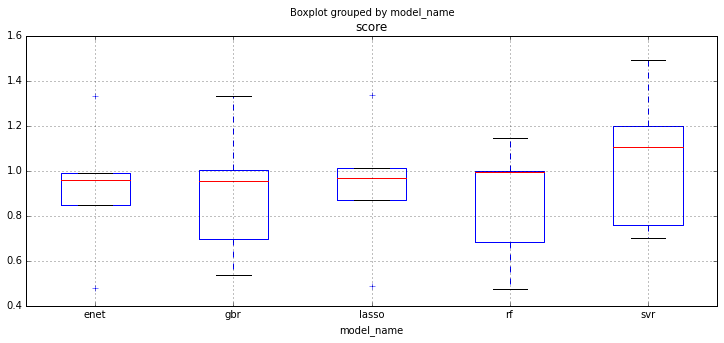

In [35]:
from sklearn.metrics import mean_squared_error

#score_func = lambda clf, y_true, y_pred: precision_score(y_true, y_pred)
score_func = lambda clf, y_true, y_pred: mean_squared_error(y_true, y_pred)

roc_scores = models.summarize_scores(res, score_func, use_proba=False)
roc_scores.boxplot('score', 'model_name', figsize=(12,5))

In [55]:
feat_imp = models.summarize_importances(res)
feat_means = feat_imp.drop('fold_id', axis=1)
feat_means = feat_means.groupby('model_name').aggregate(np.mean).T
feat_means = feat_means.abs()
feat_means.head()

model_name,enet,gbr,lasso,rf,svr
cn:A1BG,0,0,0,0,0.000417
cn:A1BG.AS1,0,0,0,0,0.000417
cn:A1CF,0,0,0,0,0.000349
cn:A2M,0,0,0,0,0.000202
cn:A2M.AS1,0,0,0,0,0.000202


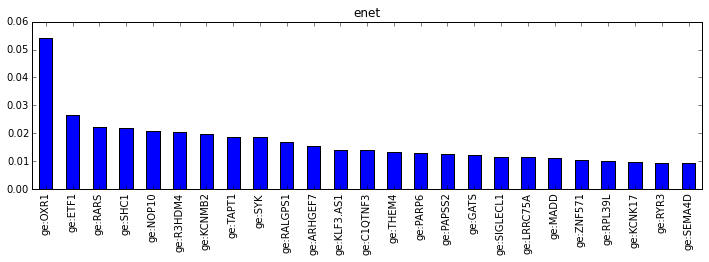

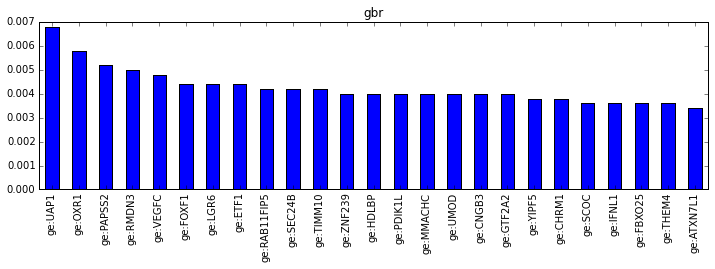

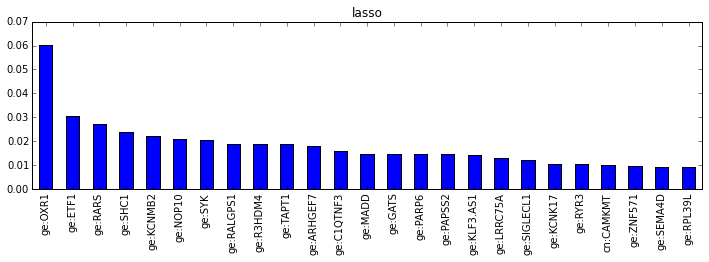

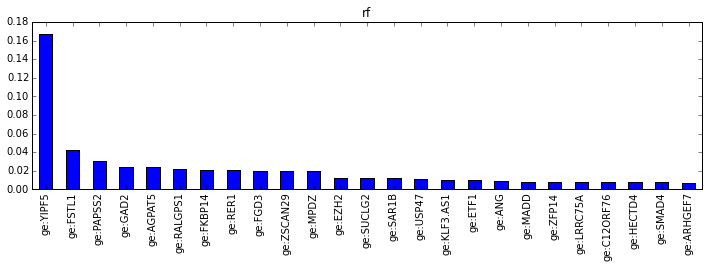

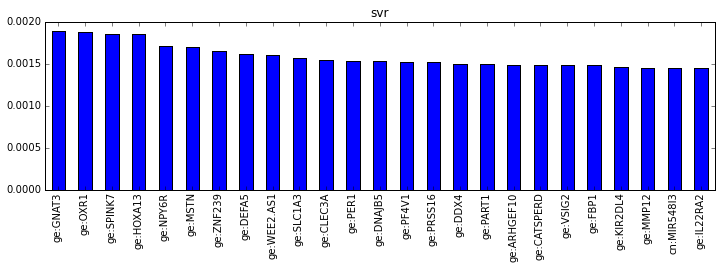

In [56]:
for model in x:
    plt.figure()
    ax = feat_means[model].order(ascending=False).head(25).plot(kind='bar', figsize=(12,3))
    ax.set_title(model)

### Out of Sample Predictions

In [38]:
preds = models.summarize_predictions(res)
preds.head()

,y_pred,y_true,model_name,fold_id
0,0.181240,0.434701,rf,1
1,0.140699,-1.109348,rf,1
2,-0.105873,1.676012,rf,1
3,-0.151969,-0.313480,rf,1
4,-0.405876,0.500955,rf,1


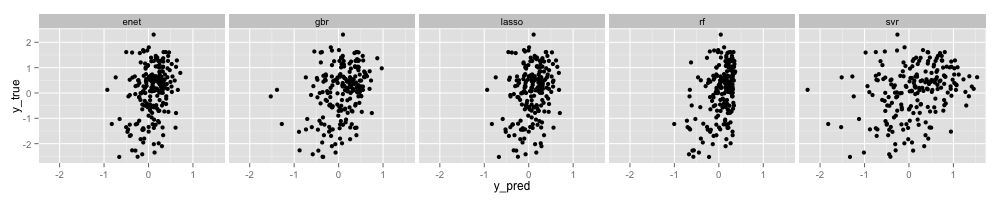

In [50]:
%%R -i preds -w 1000 -h 200 -u px
library(ggplot2)
library(dplyr)
preds %>%
    mutate(y_pred=as.numeric(y_pred), y_true=as.numeric(y_true)) %>%
    mutate(fold_id=factor(as.numeric(fold_id))) %>%
    ggplot(aes(x=y_pred, y=y_true)) + geom_point() + facet_wrap(~model_name, nrow=1)

## Comparing Feature Ranks

In [145]:
ranked_feats = feat_means.rank(ascending=False).median(axis=1).order()
ranked_feats.head()

ge:OXR1         2
ge:ETF1         7
ge:RALGPS1     10
ge:PAPSS2      16
ge:KLF3.AS1    17
dtype: float64

In [172]:
def get_top_feat_data(feats):
    feat_ranks = {feat:i+1 for i, feat in enumerate(feats)}
    d = data_tr_prep.reset_index()[feats + ['response', 'tumorID']]
    d['response'] = d['response'].astype(np.float64)
    d = pd.melt(d, id_vars=['tumorID', 'response'])
    d['rank'] = d['variable'].map(feat_ranks)
    return d

## Top Features Overall 

At TOW, they were all from the Gene Expression dataset:

In [173]:
plot_data = get_top_feat_data(ranked_feats.index[:24].tolist())
plot_data.head()

,tumorID,response,variable,value,rank
0,A2780,0.434701,ge:OXR1,-0.752222,1
1,AGS,-1.109348,ge:OXR1,-0.993599,1
2,AMO1,1.676012,ge:OXR1,-0.949704,1
3,BEN,-0.313480,ge:OXR1,-1.212011,1
4,BL70,0.500955,ge:OXR1,-0.410166,1


In [174]:
%%R
plot.feats <- function(plot_data){
    plot_data <- plot_data %>%
        mutate(value=as.numeric(value), response=as.numeric(response)) %>%
        mutate(rank=as.integer(rank), variable=paste0(as.character(variable), ' (rank =', rank, ')', sep=''))
    feat_levels <- plot_data %>% group_by(variable) %>% summarise(rank=rank[1]) %>%
        ungroup %>% arrange(rank) %>% .$variable
    plot_data %>%
        mutate(variable=factor(as.character(variable), levels=feat_levels)) %>%
        ggplot(aes(x=value, y=response)) + geom_point() + facet_wrap(~variable, ncol=4) +
        theme_bw()
}

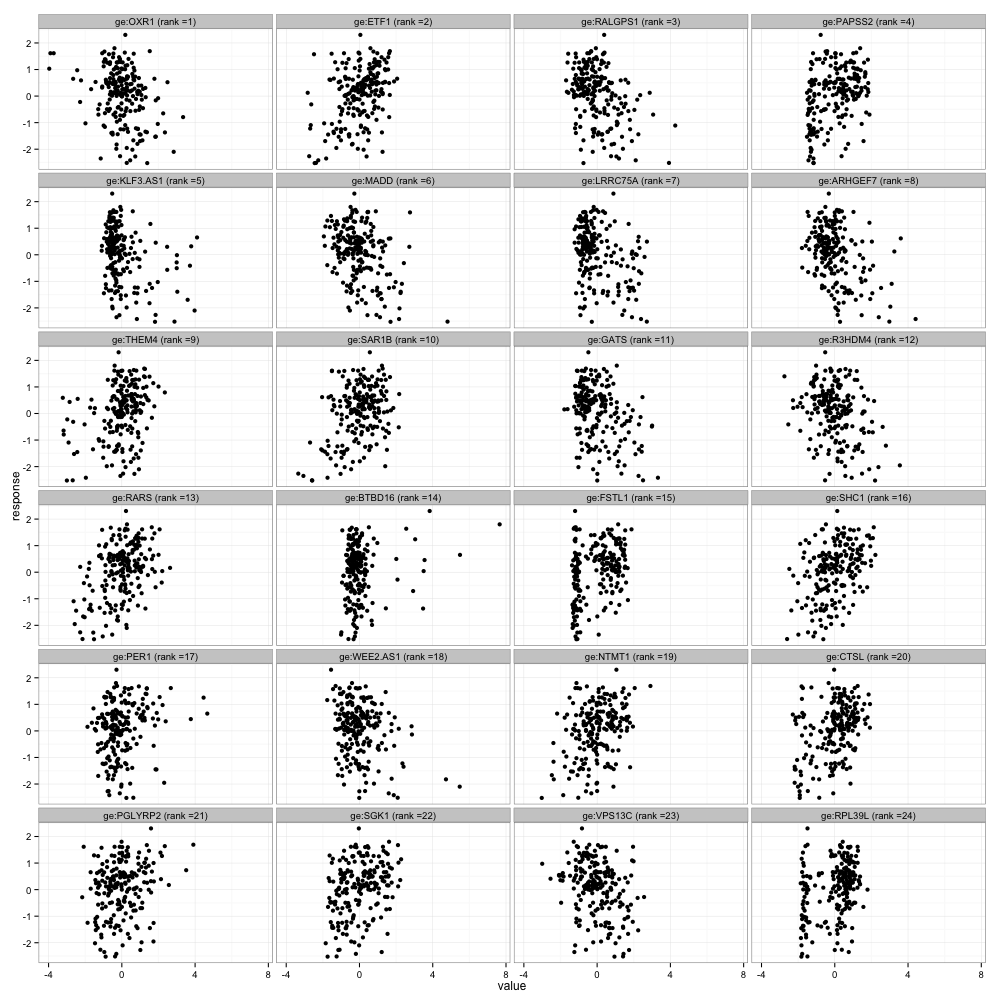

In [175]:
%%R -i plot_data -h 1000 -w 1000 -u px
plot.feats(plot_data)

## Top Copy Number Features

In [186]:
cn_feats = ranked_feats[pd.Series(ranked_feats.index).str.startswith('cn:').values].index.tolist()[:8]
plot_data = get_top_feat_data(cn_feats)
plot_data.head()

,tumorID,response,variable,value,rank
0,A2780,0.434701,cn:MAF,0.083977,1
1,AGS,-1.109348,cn:MAF,0.083977,1
2,AMO1,1.676012,cn:MAF,1.259659,1
3,BEN,-0.313480,cn:MAF,1.259659,1
4,BL70,0.500955,cn:MAF,0.083977,1


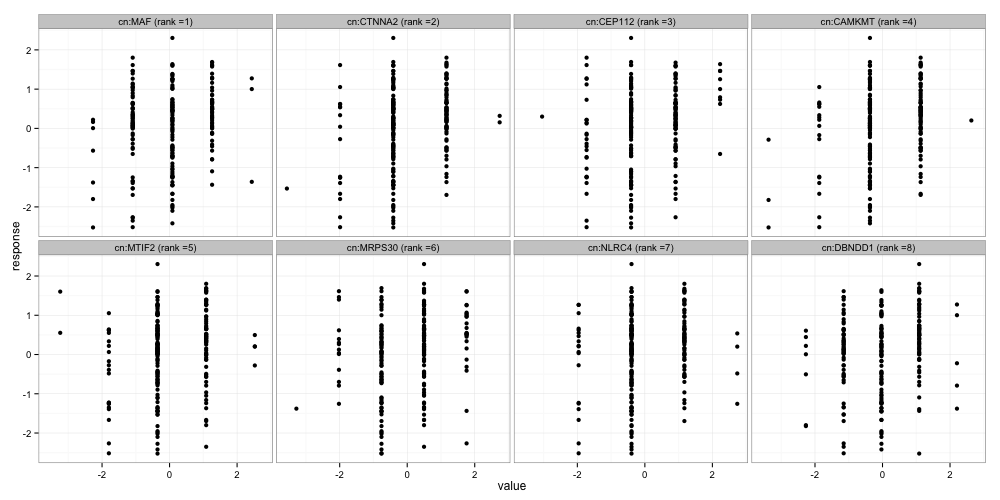

In [188]:
%%R -i plot_data -h 500 -w 1000 -u px
plot.feats(plot_data)

## Top Mutation Features

In [190]:
cn_feats = ranked_feats[pd.Series(ranked_feats.index).str.startswith('mu:').values].index.tolist()[:8]
plot_data = get_top_feat_data(cn_feats)
plot_data.head()

,tumorID,response,variable,value,rank
0,A2780,0.434701,mu:MSH6:F1088Lfs5,0,1
1,AGS,-1.109348,mu:MSH6:F1088Lfs5,0,1
2,AMO1,1.676012,mu:MSH6:F1088Lfs5,0,1
3,BEN,-0.313480,mu:MSH6:F1088Lfs5,0,1
4,BL70,0.500955,mu:MSH6:F1088Lfs5,0,1


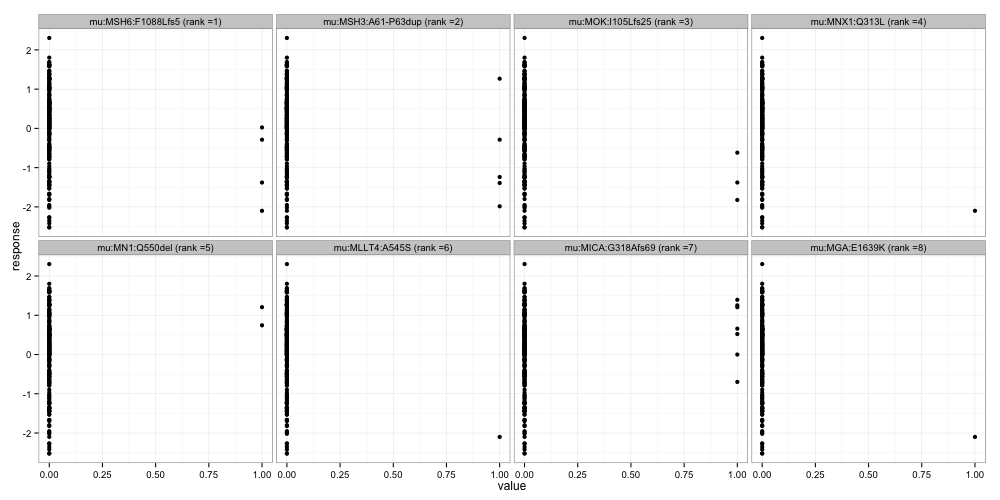

In [191]:
%%R -i plot_data -h 500 -w 1000 -u px
plot.feats(plot_data)